# VGGNet

### MiniVGGNet Archtecture

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # first CONV(3x3/32) => RELU => CONV(3x3/32) => RELU => POOL(2x2/s=2)
        model.add(Conv2D(32, (3, 3), input_shape = inputShape, padding = 'same', activation = 'relu'))
        model.add(BatchNormalization(chanDim))   # BN 추가
        model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
        model.add(BatchNormalization(chanDim))   # BN 추가
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.3))   # dropout 추가

        # second CONV(3x3/64) => RELU => CONV(3x3/64) => RELU => POOL(2x2/s=2)
        model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
        model.add(BatchNormalization(chanDim))   # BN 추가
        model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
        model.add(BatchNormalization(chanDim))   # BN 추가
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(0.3))   # dropout 추가

        # FC(512) => RELU layers
        model.add(Flatten())
        model.add(Dense(512, activation = 'relu'))
        model.add(BatchNormalization(chanDim))   # BN 추가
        model.add(Dropout(0.5))   # dropout 추가

        # softmax classifier
        model.add(Dense(classes, activation = 'softmax'))

        # return the constructed network architecture
        return model

### Mini VGGNet On MNIST

* 디스크에서 CIFAR-10 데이터 세트를 로드
* MiniVGGNet 아키텍처를 인스턴스화 
* 훈련 데이터를 사용하여 MiniVGGNet을 훈련
* 테스트 데이터로 네트워크 성능을 평가

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10

import matplotlib.pyplot as plt
import numpy as np

Loading CIFAR-10 data

In [3]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

170500096/170498071 [==============================] - 7s 0us/step


In [4]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [5]:
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
                "dog", "frog", "horse", "ship", "truck"]

Compiling model

In [6]:
opt = SGD(lr=0.01, decay=0.01/30, momentum=0.9, nesterov=True)
# learning rate 클수록 빨리감 , decay 처음에 크게 시작하고 점진적으로 작아지게함 (0.01/epochs 라고 쓰기도함)
# momentum 그래디언트값을 지정한 값만큼 쓰다가 바꿈 흘러가는방향 유지하면서 안정적으로 수렴하게 함
# nesterov 이전 그래디언트를 참조해 약간 다른 방향으로 감
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# 원래 파랑색으로 가야되는데 노랑색으로 가다가 빨간색으로 방향을 틀어야되기때문에 그걸 참조해 결과적으로 초록색으로 감

**Nesterov momentum**

$$v_{t+1} = \mu v_t - \epsilon g(\theta_t+\mu v_t)$$
$$\theta_{t+1}=\theta_t+v_{t+1}$$

모멘텀 공식과 거의 유사하지만, 현재 위치의 그래디언트 $g(\theta_t)$를 이용하는 것이 아니고 현재 위치에서 속도 $\mu v_t$ 만큼 전진한 후의 그래디언트 $g(\theta_t + \mu v_t)$를 이용

<img src="https://ruder.io/content/images/2016/09/nesterov_update_vector.png" width=400>

Training network

In [7]:
epochs = 30

H = model.fit(trainX, trainY, validation_data=(testX, testY),
    batch_size=64, epochs=epochs, verbose=1)

Epoch 1/30
782/782 [==============================] - 13s 16ms/step - loss: 1.6064 - accuracy: 0.4203 - val_loss: 1.3451 - val_accuracy: 0.5312
Epoch 2/30
782/782 [==============================] - 12s 15ms/step - loss: 1.0964 - accuracy: 0.6123 - val_loss: 1.0370 - val_accuracy: 0.6349
Epoch 3/30
782/782 [==============================] - 12s 15ms/step - loss: 0.8565 - accuracy: 0.7025 - val_loss: 0.8851 - val_accuracy: 0.6887
Epoch 4/30
782/782 [==============================] - 12s 16ms/step - loss: 0.6782 - accuracy: 0.7639 - val_loss: 0.8487 - val_accuracy: 0.7054
Epoch 5/30
782/782 [==============================] - 12s 15ms/step - loss: 0.5145 - accuracy: 0.8219 - val_loss: 0.8778 - val_accuracy: 0.7101
Epoch 6/30
782/782 [==============================] - 12s 15ms/step - loss: 0.3577 - accuracy: 0.8762 - val_loss: 0.9579 - val_accuracy: 0.7133
Epoch 7/30
782/782 [==============================] - 12s 16ms/step - loss: 0.2208 - accuracy: 0.9255 - val_loss: 1.0854 - val_accuracy:

Evaluating network

In [8]:
model.evaluate(testX, testY, batch_size=64)

157/157 [==============================] - 1s 7ms/step - loss: 2.4280 - accuracy: 0.7272


[2.4279942512512207, 0.7271999716758728]

Plot the training loss and accuracy

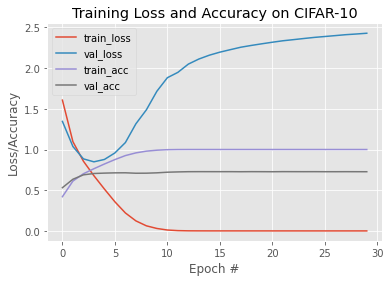

In [9]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# val_loss가 갑자기 커진이유 : loss를 최대한 줄이려고 하다보니 train에 완전 맞추며 훈련돼서 다른 데이터를 넣었을때 에러가 많이 남

### 실습1. Dropout을 적용하여 모델 학습

Compiling model

In [19]:
opt = SGD(lr=0.01, decay=0.01/30, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
                metrics=["accuracy"])

Training network

In [20]:
H = model.fit(trainX, trainY, validation_data=(testX, testY),
    batch_size=64, epochs=epochs, verbose=1)

Epoch 1/30
782/782 [==============================] - 12s 16ms/step - loss: 1.8353 - accuracy: 0.3241 - val_loss: 1.4885 - val_accuracy: 0.4542
Epoch 2/30
782/782 [==============================] - 12s 15ms/step - loss: 1.4158 - accuracy: 0.4852 - val_loss: 1.2756 - val_accuracy: 0.5420
Epoch 3/30
782/782 [==============================] - 12s 15ms/step - loss: 1.2338 - accuracy: 0.5566 - val_loss: 1.1412 - val_accuracy: 0.5939
Epoch 4/30
782/782 [==============================] - 12s 15ms/step - loss: 1.1118 - accuracy: 0.6029 - val_loss: 1.0014 - val_accuracy: 0.6461
Epoch 5/30
782/782 [==============================] - 12s 15ms/step - loss: 1.0209 - accuracy: 0.6369 - val_loss: 0.9402 - val_accuracy: 0.6681
Epoch 6/30
782/782 [==============================] - 12s 16ms/step - loss: 0.9518 - accuracy: 0.6637 - val_loss: 0.8637 - val_accuracy: 0.6930
Epoch 7/30
782/782 [==============================] - 12s 15ms/step - loss: 0.8906 - accuracy: 0.6851 - val_loss: 0.8368 - val_accuracy:

Evaluating network

In [21]:
model.evaluate(testX, testY, batch_size=64)

157/157 [==============================] - 1s 7ms/step - loss: 0.5995 - accuracy: 0.7953


[0.5995212197303772, 0.7953000068664551]

Plot the training loss and accuracy

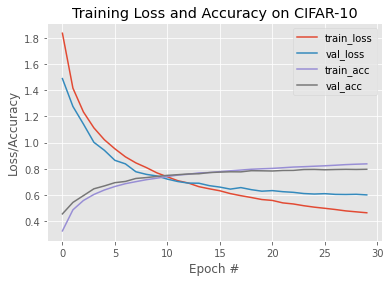

In [22]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### 실습2. 배치 정규화를 적용하고 모델 학습

Compiling model

In [24]:
opt = SGD(lr=0.01, decay=0.01/30, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
                metrics=["accuracy"])

Training network

In [25]:
H = model.fit(trainX, trainY, validation_data=(testX, testY),
    batch_size=64, epochs=epochs, verbose=1)

Epoch 1/30
782/782 [==============================] - 15s 20ms/step - loss: 1.6885 - accuracy: 0.4332 - val_loss: 1.5878 - val_accuracy: 0.4738
Epoch 2/30
782/782 [==============================] - 15s 19ms/step - loss: 1.2096 - accuracy: 0.5769 - val_loss: 1.0507 - val_accuracy: 0.6343
Epoch 3/30
782/782 [==============================] - 15s 19ms/step - loss: 1.0182 - accuracy: 0.6435 - val_loss: 1.0193 - val_accuracy: 0.6477
Epoch 4/30
782/782 [==============================] - 15s 19ms/step - loss: 0.9066 - accuracy: 0.6807 - val_loss: 0.8159 - val_accuracy: 0.7150
Epoch 5/30
782/782 [==============================] - 15s 19ms/step - loss: 0.8310 - accuracy: 0.7089 - val_loss: 0.7731 - val_accuracy: 0.7330
Epoch 6/30
782/782 [==============================] - 15s 19ms/step - loss: 0.7718 - accuracy: 0.7250 - val_loss: 0.7059 - val_accuracy: 0.7568
Epoch 7/30
782/782 [==============================] - 15s 19ms/step - loss: 0.7357 - accuracy: 0.7390 - val_loss: 0.7048 - val_accuracy:

Evaluating network

In [26]:
model.evaluate(testX, testY, batch_size=64)

157/157 [==============================] - 1s 8ms/step - loss: 0.5337 - accuracy: 0.8218


[0.5336659550666809, 0.8217999935150146]

Plot the training loss and accuracy

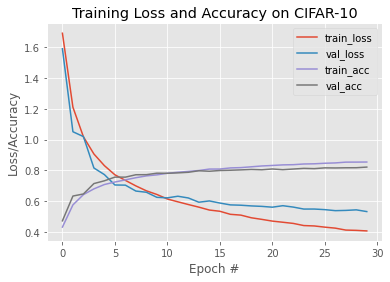

In [27]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()